# Imports

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

---

# Carga de datos

In [6]:
targets_competencia = pd.read_pickle("../../../data/tp2/ref_hashes_target.pkl")

In [3]:
features_v1 = pd.read_pickle("../features/auctions_train_ventana_1.pkl")
features_v2 = pd.read_pickle("../features/auctions_train_ventana_2.pkl")
features_v3 = pd.read_pickle("../features/auctions_train_ventana_3.pkl")
features_v4 = pd.read_pickle("../features/auctions_train_ventana_4.pkl")
features_v5 = pd.read_pickle("../features/auctions_train_ventana_5.pkl")

In [4]:
ventanas = [features_v1, features_v2, features_v3, features_v4, features_v5]

---

# Miro coincidencias para las ventanas

In [5]:
i = 1
for ventana in ventanas:
    coincidencias = pd.Series(targets_competencia.index.isin(ventana.index)).value_counts()
    porcentaje = round(100*coincidencias[True] / (coincidencias[True] + coincidencias[False]), 2)
    print("El {}% de los dispositivos de la competencia están en la ventana {}".format(porcentaje, i))
    i += 1

El 68.0% de los dispositivos de la competencia están en la ventana 1
El 69.63% de los dispositivos de la competencia están en la ventana 2
El 73.22% de los dispositivos de la competencia están en la ventana 3
El 75.15% de los dispositivos de la competencia están en la ventana 4
El 76.81% de los dispositivos de la competencia están en la ventana 5


---

# Para cada dispositivo, veo en qué ventanas aparece

In [6]:
apariciones = targets_competencia.copy()

In [7]:
for ventana_nro in range(1,6):
    apariciones["en_ventana_{}".format(ventana_nro)] = targets_competencia.index.isin(ventanas[ventana_nro - 1].index)

In [8]:
apariciones["OR"] = (apariciones["en_ventana_1"] | apariciones["en_ventana_2"] | apariciones["en_ventana_3"] | apariciones["en_ventana_4"] | apariciones["en_ventana_5"])

In [9]:
apariciones["OR"].value_counts()

True     3678
False     359
Name: OR, dtype: int64

---

# A ver si sólo entreno con dispositivos de la competencia

In [41]:
features_ventana_1_solo_competencia_auctions = ventanas[0].loc[ventanas[0].index.isin(targets_competencia.index)]

In [42]:
f2 = pd.read_pickle("../features/clicks_train_ventana_3.pkl")
f3 = pd.read_pickle("../features/events_train_ventana_3.pkl")

In [54]:
todos_features  = features_ventana_1_solo_competencia_auctions.merge(f2, left_index=True, right_index=True) \
                                            .merge(f3, left_index=True, right_index=True)

In [55]:
len(todos_features)

2795

In [56]:
labels = pd.read_pickle("../../modelo/targets/targets_ventana_1_auctions.pkl")

In [59]:
train = todos_features.merge(labels, left_index=True, right_index=True)

In [ ]:
X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':5,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.01}


num_round = 5000
stopping = 15
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

RMSE: 80292.24933623662


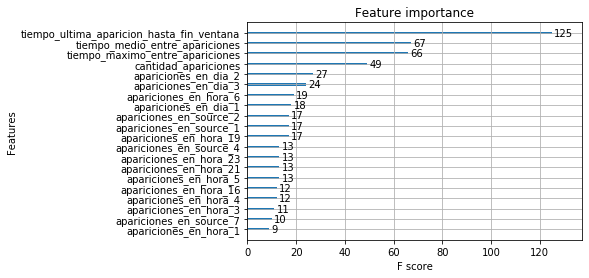

In [33]:
# fit model on all training data
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: {}".format(sqrt(rmse)))

xgb.plot_importance(model, max_num_features=20)
pyplot.show()

RMSE: 58401.53882651617


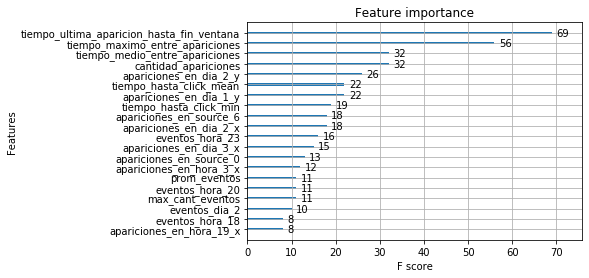

In [68]:
# fit model on all training data
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: {}".format(sqrt(rmse)))

xgb.plot_importance(model, max_num_features=20)
pyplot.show()

## Conclusion: Como al parecer usar features de varios datasets mejora considerablemente la puntuación, voy a tratar de crear features para personas "similares" a las de la competencia. Esto es, crear features sólo con los dispositivos de la competencia y aquellos otros que tengan la misma presencia en los datos (que se puedan calcular los mismos features)

---

# Pruebo con solo dispositivos de la competencia

In [3]:
auctions = pd.read_pickle("../../../data/tp2/auctions_tp2_formateado.pkl")

In [4]:
# Creo columnas para luego separar
auctions['hora'] = auctions['date'].dt.hour
auctions['dia'] = auctions['date'].dt.day
auctions['dia_de_la_semana'] = auctions['date'].dt.dayofweek

In [7]:
targets_competencia = pd.read_pickle("../../../data/tp2/ref_hashes_target.pkl")

In [8]:
auctions_competencia = auctions.loc[auctions["device_id"].isin(targets_competencia.index)].copy()

In [9]:
for ventana_nro in range(1,5):
    auctions_competencia["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= auctions_competencia["date"].dt.day) & ((auctions_competencia["date"].dt.day) <= (19+ventana_nro)))

In [10]:
auctions_competencia = auctions_competencia.loc[(auctions_competencia["ventana_1"]) | (auctions_competencia["ventana_2"]) | (auctions_competencia["ventana_3"]) | (auctions_competencia["ventana_4"])]

# Entreno hasta la ventana 4 que es la ultima que esta completa

## Tiempo medio todas las ventanas

In [11]:
targets_competencia.index.rename("device_id", inplace=True)

In [12]:
gb = auctions_competencia.groupby("device_id")
ps = {}
for t, g in gb:
    ps[t] = g["date"].sub(g["date"].shift()).mean()
targets_competencia["tiempo_medio_entre_apariciones_todas_las_ventanas"] = pd.Series(ps).dt.total_seconds().to_frame().rename(columns={0: "tiempo_medio_entre_apariciones_todas_las_ventanas"})

---

## Función generadora de features

In [13]:
def generar_feature_en_ventanas(dataframe, generador_feature, destino):
    for ventana_nro in range(1, 5):
        feature = generador_feature(dataframe.loc[dataframe["ventana_{}".format(ventana_nro)]], ventana_nro)
        destino[(feature.columns[0] + "_v{}".format(ventana_nro))] = feature[feature.columns[0]]

---

## Cantidad de apariciones en subastas dentro de la ventana

In [14]:
def cantidad_apariciones_en_subastas(dataframe, nro_ventana):
    return dataframe.groupby("device_id").agg({"date" : "count"}).rename(columns={"date": "cantidad_apariciones"})

In [15]:
generar_feature_en_ventanas(auctions_competencia, cantidad_apariciones_en_subastas, targets_competencia)

---

## Apariciones por dia

In [16]:
auctions_competencia["para_contar"] = 1

In [17]:
apariciones_por_dia = auctions_competencia.groupby(["device_id", "dia"]).agg({"para_contar" : "count"}).unstack().fillna(0).stack()

In [18]:
feature = apariciones_por_dia.unstack().droplevel(axis=1, level=1)

In [19]:
feature.columns = ["dia_{}".format(x) for x in range(18,24)]

In [20]:
targets_competencia = targets_competencia.merge(feature, left_index=True, right_index=True, how="left")

---

## Acumulativo de apariciones por dia

In [21]:
acum_por_dia = auctions_competencia.groupby(["device_id", "dia"]).agg({"para_contar" : "count"}).unstack().fillna(0).cumsum(axis=1)
acum_por_dia.columns = ["apariciones_hasta_dia_{}".format(x) for x in range(18, 24)]
targets_competencia = targets_competencia.merge(acum_por_dia, left_index=True, right_index=True, how="left")

---

## Tiempo medio por ventana

In [22]:
def tiempo_medio(dataframe, nro_ventana):
    gb = auctions_competencia.groupby("device_id")
    ps = {}
    for t, g in gb:
        ps[t] = g["date"].sub(g["date"].shift()).mean()
    return pd.Series(ps).dt.total_seconds().to_frame().rename(columns={0: "tiempo_medio_entre_apariciones"})

In [23]:
generar_feature_en_ventanas(auctions_competencia, tiempo_medio, targets_competencia)

---

## Label ventanas anteriores

In [24]:
labels_v1 = pd.read_pickle("../targets/targets_ventana_1_auctions.pkl")
labels_v1.columns = ["label_v1"]
labels_v2 = pd.read_pickle("../targets/targets_ventana_2_auctions.pkl")
labels_v2.columns = ["label_v2"]
labels_v3 = pd.read_pickle("../targets/targets_ventana_3_auctions.pkl")
labels_v3.columns = ["label_v3"]

In [25]:
targets_competencia = targets_competencia.merge(labels_v1, left_index=True, right_index=True, how="left")
targets_competencia = targets_competencia.merge(labels_v2, left_index=True, right_index=True, how="left")
targets_competencia = targets_competencia.merge(labels_v3, left_index=True, right_index=True, how="left")

In [26]:
targets_competencia["label_v1"] = targets_competencia["label_v1"].fillna(259200)
targets_competencia["label_v2"] = targets_competencia["label_v2"].fillna(259200)
targets_competencia["label_v3"] = targets_competencia["label_v3"].fillna(259200)

---

## Tiempo desde ultima aparicion en ventana hasta fin ventana

In [27]:
def tiempo_desde_ult_aparicion_hasta_fin_ventana(dataframe, nro_ventana):
    return (np.datetime64("2019-04-2{}".format(nro_ventana)) - dataframe.groupby("device_id").agg({"date" : "max"})["date"]).dt.total_seconds().to_frame().rename(columns={"date": "tiempo_ultima_aparicion_hasta_fin_ventana"})

In [28]:
generar_feature_en_ventanas(auctions_competencia, tiempo_desde_ult_aparicion_hasta_fin_ventana, targets_competencia)

---

## Tiempo desde primera aparición en ventana hasta fin ventana

In [29]:
def tiempo_desde_primera_aparicion_hasta_fin_ventana(dataframe, nro_ventana):
    return (np.datetime64("2019-04-2{}".format(nro_ventana)) - dataframe.groupby("device_id").agg({"date" : "min"})["date"]).dt.total_seconds().to_frame().rename(columns={"date": "tiempo_primera_aparicion_hasta_fin_ventana"})

In [30]:
generar_feature_en_ventanas(auctions_competencia, tiempo_desde_primera_aparicion_hasta_fin_ventana, targets_competencia)

---

## Ultima vez que se lo vio hasta la ventana de train y test (4)

In [31]:
feature = (np.datetime64("2019-04-24") - auctions_competencia.groupby("device_id").agg({"date" : "max"})["date"]).dt.total_seconds().to_frame().rename(columns={"date": "tiempo_ultima_aparicion_hasta_fin_ventana_train"})

In [32]:
targets_competencia = targets_competencia.merge(feature, left_index=True, right_index=True, how="left")

---

## Primera vez que se lo vio hasta la ventana de train y test (4)

In [33]:
feature = (np.datetime64("2019-04-24") - auctions_competencia.groupby("device_id").agg({"date" : "min"})["date"]).dt.total_seconds().to_frame().rename(columns={"date": "tiempo_primera_aparicion_hasta_fin_ventana_train"})

In [34]:
targets_competencia = targets_competencia.merge(feature, left_index=True, right_index=True, how="left")

---

# Pruebo modelo

In [35]:
labels_v4 = pd.read_pickle("../targets/targets_ventana_4_auctions.pkl")
train = targets_competencia.merge(labels_v4, left_index=True, right_index=True, how="left")
train["target"] = train["target"].fillna(259200)

In [36]:
X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [37]:
xg_reg = xgb.XGBRegressor(n_jobs=6)

In [38]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [40]:
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 56123.679012


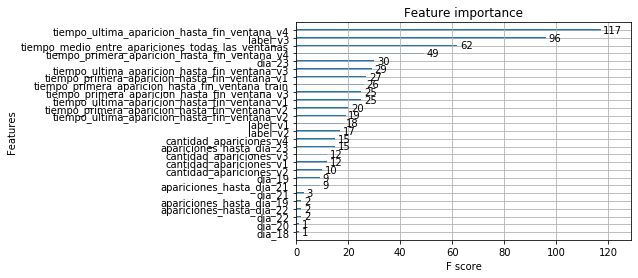

In [47]:
xgb.plot_importance(xg_reg)

# Random search

In [46]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

"""space ={
        'max_depth': hp.choice('max_depth', ),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'silent' : 1
}
"""

space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 1000+1)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'objective': 'reg:linear',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': 123
}


def objective(space):
    model = xgb.train(space, dtrain,evals=[(dtest, "test")], verbose_eval=False)
    pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    #print("RMSE: {}".format(rmsee)) 

    return{'loss':rmse, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)

print(best)
#100%|██████████| 1000/1000 [02:47<00:00,  4.30it/s, best loss: 55400.115263399275]
#{'colsample_bytree': 0.8, 'eta': 0.45, 'gamma': 0.9500000000000001, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 86, 'subsample': 0.7000000000000001}

100%|██████████| 1000/1000 [02:47<00:00,  4.30it/s, best loss: 55400.115263399275]
{'colsample_bytree': 0.8, 'eta': 0.45, 'gamma': 0.9500000000000001, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 86, 'subsample': 0.7000000000000001}
